In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings

In [78]:
# Load training data
train_df = pd.read_csv('../data/train.csv')
print(f"Training data shape: {train_df.shape}")

Training data shape: (1460, 81)


In [79]:
# Check for missing values in features
missing_percent = (train_df.isnull().sum() / len(train_df)) * 100
missing_data = pd.DataFrame({'Missing_Percent': missing_percent})
missing_data = missing_data[missing_data['Missing_Percent'] > 0].sort_values('Missing_Percent', ascending=False)
print(f"\nFeatures with missing values: {len(missing_data)}")
print(missing_data.head(10))


Features with missing values: 19
              Missing_Percent
PoolQC              99.520548
MiscFeature         96.301370
Alley               93.767123
Fence               80.753425
MasVnrType          59.726027
FireplaceQu         47.260274
LotFrontage         17.739726
GarageType           5.547945
GarageYrBlt          5.547945
GarageFinish         5.547945


In [80]:
# Verify SalePrice statistics
print("\nSalePrice statistics:")
print(f"  Min: ${train_df['SalePrice'].min():,.0f}")
print(f"  33rd percentile: ${train_df['SalePrice'].quantile(0.33):,.0f}")
print(f"  Median (50th): ${train_df['SalePrice'].quantile(0.50):,.0f}")
print(f"  67th percentile: ${train_df['SalePrice'].quantile(0.67):,.0f}")
print(f"  Max: ${train_df['SalePrice'].max():,.0f}")


SalePrice statistics:
  Min: $34,900
  33rd percentile: $139,000
  Median (50th): $163,000
  67th percentile: $191,000
  Max: $755,000


In [81]:
# Define category boundaries based on percentiles
low_threshold = train_df['SalePrice'].quantile(0.33)
high_threshold = train_df['SalePrice'].quantile(0.67)

print(f"\nCategory boundaries:")
print(f"  Low: < ${low_threshold:,.0f}")
print(f"  Medium: ${low_threshold:,.0f} - ${high_threshold:,.0f}")
print(f"  High: > ${high_threshold:,.0f}")


Category boundaries:
  Low: < $139,000
  Medium: $139,000 - $191,000
  High: > $191,000


In [82]:
# Create categories: 0 = Low, 1 = Medium, 2 = High
def categorize_price(price):
    if price < low_threshold:
        return 0  # Low
    elif price < high_threshold:
        return 1  # Medium
    else:
        return 2  # High

In [83]:
train_df['PriceCategory'] = train_df['SalePrice'].apply(categorize_price)

In [84]:
# Check class balance
print(f"\nClass distribution:")
print(train_df['PriceCategory'].value_counts().sort_index())
print(f"\nClass proportions:")
print(train_df['PriceCategory'].value_counts(normalize=True).sort_index())


Class distribution:
PriceCategory
0    472
1    505
2    483
Name: count, dtype: int64

Class proportions:
PriceCategory
0    0.323288
1    0.345890
2    0.330822
Name: proportion, dtype: float64


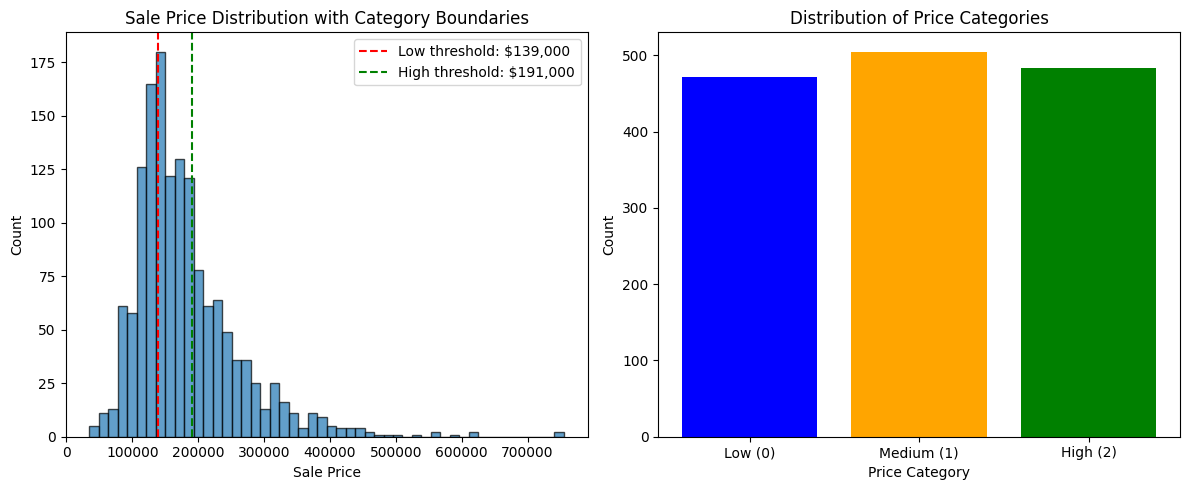

In [85]:
# Visualize the price distribution and categories
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(train_df['SalePrice'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(low_threshold, color='r', linestyle='--', label=f'Low threshold: ${low_threshold:,.0f}')
plt.axvline(high_threshold, color='g', linestyle='--', label=f'High threshold: ${high_threshold:,.0f}')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.title('Sale Price Distribution with Category Boundaries')
plt.legend()

plt.subplot(1, 2, 2)
category_counts = train_df['PriceCategory'].value_counts().sort_index()
plt.bar(['Low (0)', 'Medium (1)', 'High (2)'], category_counts.values, color=['blue', 'orange', 'green'])
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.title('Distribution of Price Categories')

plt.tight_layout()
plt.show()

In [86]:
# Separate features and target
# Remove SalePrice and PriceCategory from features, and Id if present
features_to_drop = ['SalePrice', 'PriceCategory']
if 'Id' in train_df.columns:
    features_to_drop.append('Id')

X = train_df.drop(columns=features_to_drop)
y = train_df['PriceCategory']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")


Features shape: (1460, 79)
Target shape: (1460,)


In [87]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")


Numeric features: 36
Categorical features: 43


In [107]:
# Handle missing values
# For numeric: fill with median
for col in numeric_features:
    if X[col].isnull().any():
        X[col].fillna(X[col].median(), inplace=True)

# For categorical: fill with mode (most frequent value)
for col in categorical_features:
    if X[col].isnull().any():
        X[col].fillna(X[col].mode()[0], inplace=True)

print(f"\nMissing values after imputation: {X.isnull().sum().sum()}")


Missing values after imputation: 0


In [108]:
# Encode categorical variables using one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
print(f"\nShape after encoding: {X_encoded.shape}")
print(f"Total features: {X_encoded.shape[1]}")


Shape after encoding: (1460, 244)
Total features: 244


In [109]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts().sort_index())


Training set size: 1095
Validation set size: 365

Training set class distribution:
PriceCategory
0    354
1    379
2    362
Name: count, dtype: int64


In [110]:
# Standardize features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"\nFeature scaling complete.")
print(f"Training features mean: {X_train_scaled.mean():.6f}")
print(f"Training features std: {X_train_scaled.std():.6f}")


Feature scaling complete.
Training features mean: -0.000000
Training features std: 0.995893


In [111]:
# ============================================================================
# 5. Train Logistic Regression Model
# ============================================================================

# Initialize and train the model
# For multi-class classification, we use 'multinomial' solver
lgr = LogisticRegression(
    solver='lbfgs',  # Better for multi-class
    multi_class='multinomial',
    max_iter=1000,
    random_state=42
)

print("\nTraining logistic regression model...")
lgr.fit(X_train_scaled, y_train)
print("Training complete!")


Training logistic regression model...
Training complete!


/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/hayden/

In [112]:
# ============================================================================
# 6. Evaluate on Validation Set
# ============================================================================

# Make predictions on validation set
y_pred_val = lgr.predict(X_val_scaled)
y_pred_proba_val = lgr.predict_proba(X_val_scaled)

/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [94]:
# Calculate accuracy
accuracy_val = accuracy_score(y_val, y_pred_val)
print(f"\nValidation Accuracy: {accuracy_val:.4f} ({accuracy_val*100:.2f}%)")


Validation Accuracy: 0.8082 (80.82%)


In [95]:
# Detailed classification report
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred_val, target_names=['Low', 'Medium', 'High']))


Classification Report (Validation Set):
              precision    recall  f1-score   support

         Low       0.86      0.84      0.85       118
      Medium       0.71      0.76      0.73       126
        High       0.88      0.83      0.85       121

    accuracy                           0.81       365
   macro avg       0.81      0.81      0.81       365
weighted avg       0.81      0.81      0.81       365



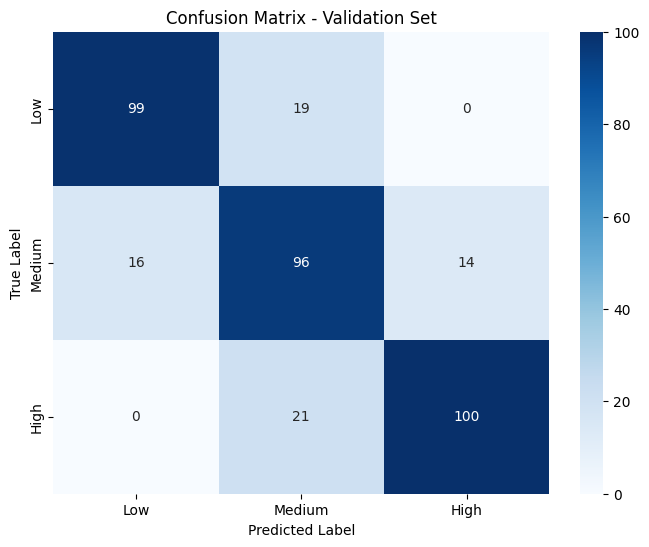


Confusion Matrix:
[[ 99  19   0]
 [ 16  96  14]
 [  0  21 100]]


In [113]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Validation Set')
plt.show()

print(f"\nConfusion Matrix:")
print(cm)

In [97]:
# ============================================================================
# 7. Train on Full Training Data and Predict on Test Set
# ============================================================================

# Retrain on full training data for final model
print("\nRetraining on full training set...")
X_full_scaled = scaler.fit_transform(X_encoded)
lgr_final = LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=1000,
    random_state=42
)
lgr_final.fit(X_full_scaled, y)
print("Final model training complete!")


Retraining on full training set...
Final model training complete!


/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:203: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights.T + intercept  # ndarray, likely C-contiguous
/Users/hayden/

In [98]:
# Load test data
test_df = pd.read_csv('../data/test.csv')
print(f"\nTest data shape: {test_df.shape}")

# Store test IDs if present
if 'Id' in test_df.columns:
    test_ids = test_df['Id'].copy()
    test_df_processed = test_df.drop(columns=['Id'])
else:
    test_ids = None
    test_df_processed = test_df.copy()


Test data shape: (1459, 80)


In [114]:
# Preprocess test data (same steps as training data)
# Handle missing values
test_numeric = test_df_processed.select_dtypes(include=[np.number]).columns.tolist()
test_categorical = test_df_processed.select_dtypes(include=['object']).columns.tolist()

for col in test_numeric:
    if test_df_processed[col].isnull().any():
        # Use training data statistics for consistency
        fill_value = X[col].median() if col in X.columns else test_df_processed[col].median()
        test_df_processed[col].fillna(fill_value, inplace=True)

for col in test_categorical:
    if test_df_processed[col].isnull().any():
        fill_value = X[col].mode()[0] if col in X.columns else test_df_processed[col].mode()[0]
        test_df_processed[col].fillna(fill_value, inplace=True)

print(f"\nMissing values in test set after imputation: {test_df_processed.isnull().sum().sum()}")


Missing values in test set after imputation: 0


In [100]:
# Encode categorical variables
test_encoded = pd.get_dummies(test_df_processed, columns=test_categorical, drop_first=True)

In [101]:
# Align test set columns with training set
# Add missing columns with 0s
missing_cols = set(X_encoded.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0

# Remove extra columns not in training
extra_cols = set(test_encoded.columns) - set(X_encoded.columns)
test_encoded = test_encoded.drop(columns=list(extra_cols))

# Reorder columns to match training data
test_encoded = test_encoded[X_encoded.columns]

In [115]:
# Scale test features
X_test_scaled = scaler.transform(test_encoded)

# Make predictions
y_pred_test = lgr_final.predict(X_test_scaled)
y_pred_proba_test = lgr_final.predict_proba(X_test_scaled)

print(f"\nTest set predictions complete!")
print(f"\nPredicted category distribution:")
unique, counts = np.unique(y_pred_test, return_counts=True)
for cat, count in zip(unique, counts):
    cat_name = ['Low', 'Medium', 'High'][cat]
    print(f"  {cat_name} ({cat}): {count} ({count/len(y_pred_test)*100:.1f}%)")


Test set predictions complete!

Predicted category distribution:
  Low (0): 105 (7.2%)
  Medium (1): 1341 (91.9%)
  High (2): 13 (0.9%)


/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/hayden/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [103]:
# Create results dataframe
results_df = pd.DataFrame({
    'PredictedCategory': y_pred_test,
    'CategoryName': [['Low', 'Medium', 'High'][cat] for cat in y_pred_test],
    'Probability_Low': y_pred_proba_test[:, 0],
    'Probability_Medium': y_pred_proba_test[:, 1],
    'Probability_High': y_pred_proba_test[:, 2]
})

if test_ids is not None:
    results_df.insert(0, 'Id', test_ids.values)

print("\nFirst 10 predictions:")
print(results_df.head(10))


First 10 predictions:
     Id  PredictedCategory CategoryName  Probability_Low  Probability_Medium  \
0  1461                  1       Medium     8.473029e-06            0.999992   
1  1462                  1       Medium     2.190665e-16            1.000000   
2  1463                  1       Medium     1.268859e-13            1.000000   
3  1464                  1       Medium     3.020613e-14            1.000000   
4  1465                  1       Medium     5.461354e-06            0.999995   
5  1466                  1       Medium     2.901081e-12            1.000000   
6  1467                  1       Medium     3.324247e-13            1.000000   
7  1468                  1       Medium     6.808423e-12            1.000000   
8  1469                  1       Medium     7.934177e-14            1.000000   
9  1470                  1       Medium     7.829739e-04            0.999217   

   Probability_High  
0      7.957826e-18  
1      9.062982e-18  
2      1.209018e-12  
3      2

In [104]:
print("\n" + "="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"Model Type: Logistic Regression (Multinomial)")
print(f"Number of features: {X_encoded.shape[1]}")
print(f"Number of classes: 3 (Low, Medium, High)")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(test_df)}")
print(f"\nValidation Accuracy: {accuracy_val:.4f} ({accuracy_val*100:.2f}%)")
print(f"\nCategory Thresholds:")
print(f"  Low: < ${low_threshold:,.0f}")
print(f"  Medium: ${low_threshold:,.0f} - ${high_threshold:,.0f}")
print(f"  High: > ${high_threshold:,.0f}")
print("="*60)


MODEL SUMMARY
Model Type: Logistic Regression (Multinomial)
Number of features: 244
Number of classes: 3 (Low, Medium, High)
Training samples: 1095
Validation samples: 365
Test samples: 1459

Validation Accuracy: 0.8082 (80.82%)

Category Thresholds:
  Low: < $139,000
  Medium: $139,000 - $191,000
  High: > $191,000
